In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from pathlib import Path
sys.path.append('/content/drive/MyDrive/RCNN_tutor')
path = Path('/content/drive/MyDrive/RCNN_tutor')

In [1]:
from pathlib import Path
path = Path('/home/pc0/projects/RCNN_tutor/')

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader

import rcnn_utils
import image_utils
from object_detection_dataset import ObjectDetectionDataset

In [3]:
from object_detection_dataset import ObjectDetectionDataset
??ObjectDetectionDataset

Init signature:
ObjectDetectionDataset(
    annotation_path: pathlib.Path,
    img_dir: pathlib.Path,
    img_size: Tuple[int, int],
    name2index: Dict[str, int],
)
Source:        
class ObjectDetectionDataset(Dataset):
    """
    A Pytorch Dataset class to load the images and
    their corresponding annotations.

    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    """
    def __init__(
        self,
        annotation_path: Path,
        img_dir: Path,
        img_size: Tuple[int, int],
        name2index: Dict[str, int]
    ):
        self.img_size = img_size
        self.bboxes, self.labels, self.img_paths = self.parse_annotation(
            annotation_path, img_size, img_dir, name2index)

    def __len__(self):
        return len(self.labels)

    def __getitem__(
        self, idx: int
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

In [4]:
annotation_path = path.joinpath('data/annotations.xml')
img_dir = path.joinpath('data/images')
name2index = {'pad': -1, 'camel': 0, 'bird': 1}
index2name = {-1: 'pad', 0: 'camel', 1: 'bird'}
img_width = 640
img_height = 480

dset = ObjectDetectionDataset(annotation_path, img_dir, (img_width, img_height),
                              name2index)

print(dset.bboxes)
print(dset.labels)
print(dset.img_paths, '\n')
print(dset[0][0].shape)

tensor([[[ 32.,  65., 328., 352.],
         [408., 148., 612., 368.],
         [ -1.,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1.,  -1.]],

        [[413., 208., 566., 323.],
         [215., 221., 418., 446.],
         [182.,  53., 348., 213.],
         [ 58., 116., 271., 307.],
         [281., 182., 429., 273.],
         [ 65., 322., 226., 453.]]])
tensor([[ 0.,  0., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.]])
[PosixPath('/home/pc0/projects/RCNN_tutor/data/images/0462.png'), PosixPath('/home/pc0/projects/RCNN_tutor/data/images/0896.png')] 

torch.Size([3, 480, 640])


<Axes: >

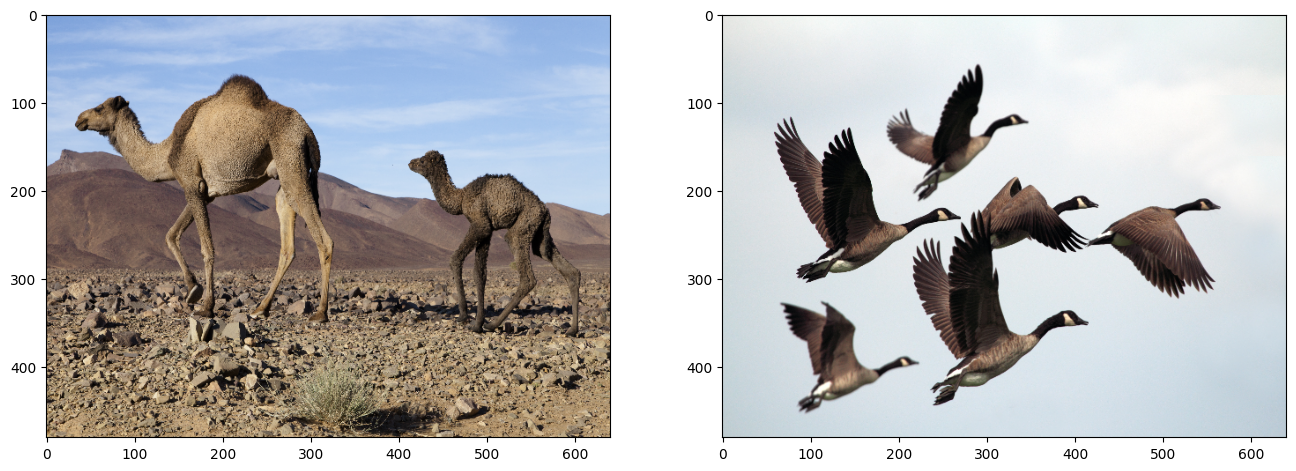

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])

<Axes: >

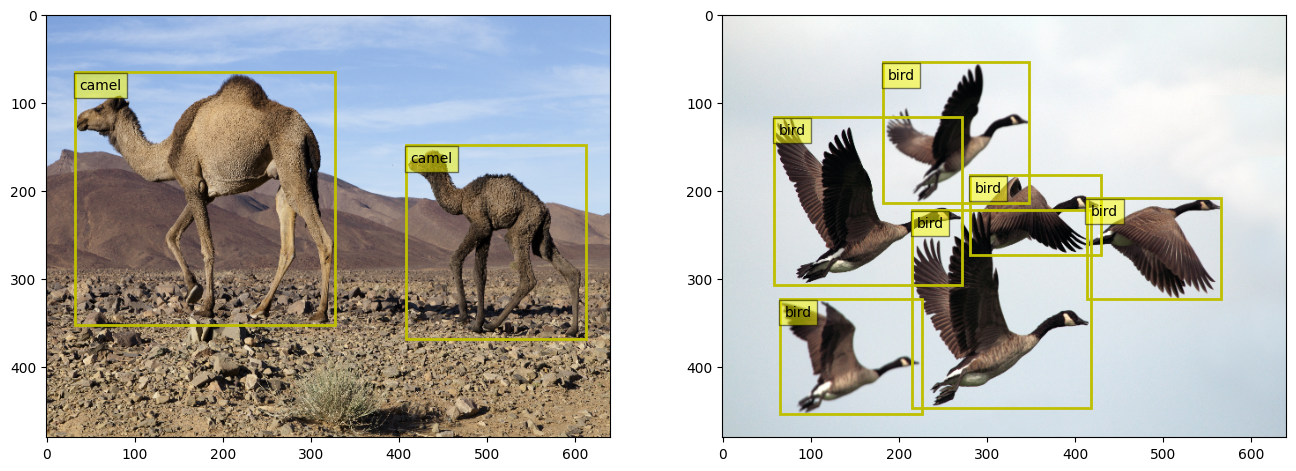

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])
rcnn_utils.draw_bounding_boxes(axes[0], *[*dset[0]][1:], index2name)
rcnn_utils.draw_bounding_boxes(axes[1], *[*dset[1]][1:], index2name)

In [7]:
dloader = DataLoader(dset, batch_size=2)
sample = next(iter(dloader))
sample

[tensor([[[[0.4941, 0.4980, 0.5020,  ..., 0.6000, 0.6039, 0.6000],
           [0.4902, 0.4902, 0.4902,  ..., 0.5961, 0.5882, 0.5882],
           [0.4941, 0.4902, 0.4941,  ..., 0.5882, 0.5765, 0.5804],
           ...,
           [0.6980, 0.7059, 0.7725,  ..., 0.5725, 0.5608, 0.5216],
           [0.8275, 0.8314, 0.8353,  ..., 0.7490, 0.7176, 0.6902],
           [0.7922, 0.8471, 0.8157,  ..., 0.7216, 0.7294, 0.6784]],
 
          [[0.6353, 0.6392, 0.6353,  ..., 0.7216, 0.7255, 0.7216],
           [0.6353, 0.6314, 0.6275,  ..., 0.7216, 0.7098, 0.7137],
           [0.6353, 0.6314, 0.6314,  ..., 0.7137, 0.7098, 0.7137],
           ...,
           [0.5608, 0.5686, 0.6667,  ..., 0.4941, 0.4824, 0.4235],
           [0.7176, 0.7373, 0.7451,  ..., 0.6314, 0.6000, 0.5922],
           [0.7020, 0.7569, 0.7255,  ..., 0.6314, 0.6431, 0.5922]],
 
          [[0.8549, 0.8549, 0.8549,  ..., 0.9020, 0.9020, 0.9020],
           [0.8510, 0.8510, 0.8510,  ..., 0.9059, 0.8941, 0.8980],
           [0.8510, 0.85

In [8]:
resnet = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.DEFAULT)
backbone = torch.nn.Sequential(*list(resnet.children())[:8])

In [9]:
backbone_out = backbone(sample[0])

In [10]:
b, out_c, out_h, out_w = backbone_out.shape
print(b, out_c, out_h, out_w)

2 2048 15 20


In [11]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
print(height_scale_factor, width_scale_factor)

32 32


<Axes: >

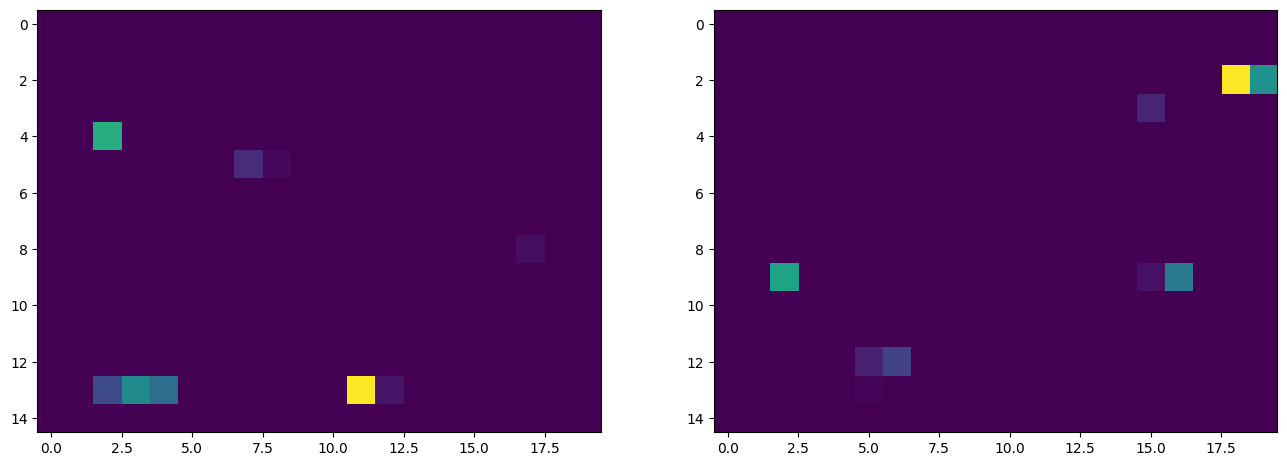

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# Second index of backbone_out can be configured for showing other maps.
image_utils.display_image(backbone_out[0][3].detach().numpy(), axes[0])
image_utils.display_image(backbone_out[1][6].detach().numpy(), axes[1])

In [13]:
x_anchors, y_anchors = rcnn_utils.generate_anchors((out_h, out_w))
print('Feature map anchors:', x_anchors, y_anchors, sep='\n')
x_anchors *= width_scale_factor
y_anchors *= height_scale_factor
print('Anchors scaled to image sizes:', x_anchors, y_anchors, sep='\n')

Feature map anchors:
tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,  7.5000,
         8.5000,  9.5000, 10.5000, 11.5000, 12.5000, 13.5000, 14.5000, 15.5000,
        16.5000, 17.5000, 18.5000, 19.5000])
tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,  7.5000,
         8.5000,  9.5000, 10.5000, 11.5000, 12.5000, 13.5000, 14.5000])
Anchors scaled to image sizes:
tensor([ 16.,  48.,  80., 112., 144., 176., 208., 240., 272., 304., 336., 368.,
        400., 432., 464., 496., 528., 560., 592., 624.])
tensor([ 16.,  48.,  80., 112., 144., 176., 208., 240., 272., 304., 336., 368.,
        400., 432., 464.])


<Axes: >

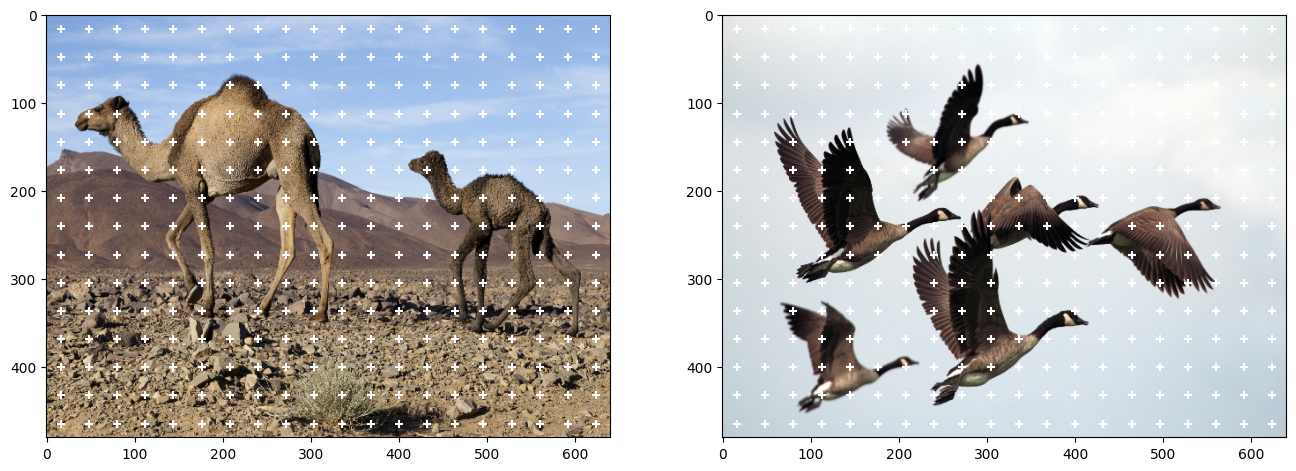

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
image_utils.display_image(dset[0][0], axes[0])
image_utils.display_image(dset[1][0], axes[1])
rcnn_utils.show_anchors(x_anchors, y_anchors, axes[0])
rcnn_utils.show_anchors(x_anchors, y_anchors, axes[1])

In [15]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
# number of anchor boxes for each anchor point
# n_anc_boxes = len(anc_scales) * len(anc_ratios)

anc_base = rcnn_utils.generate_anchor_boxes(
    x_anchors, y_anchors, anc_scales, anc_ratios, (out_h, out_w))

# Faster R-CNN in Pytorch with Example

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from rcnn_utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

[autoreload of my_utils failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/content/drive/MyDrive/RCNN_tutor/my_utils.py", line 198
    def generate_anchor_bboxe

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [ ]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        
        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)
            
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [ ]:
img_width = 640
img_height = 480
annotation_path = str(path.joinpath('data/annotations.xml'))
image_dir = str(path.joinpath('data/images'))
name2idx = {'pad': -1, 'camel': 0, 'bird': 1}
idx2name = {v:k for k, v in name2idx.items()}

#### Create Dataset and Dataloaders

In [ ]:
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

In [ ]:
od_dataloader = DataLoader(od_dataset, batch_size=2)

#### Grab a batch for demonstration

In [ ]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

### Display Images and Bounding Boxes

In [ ]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

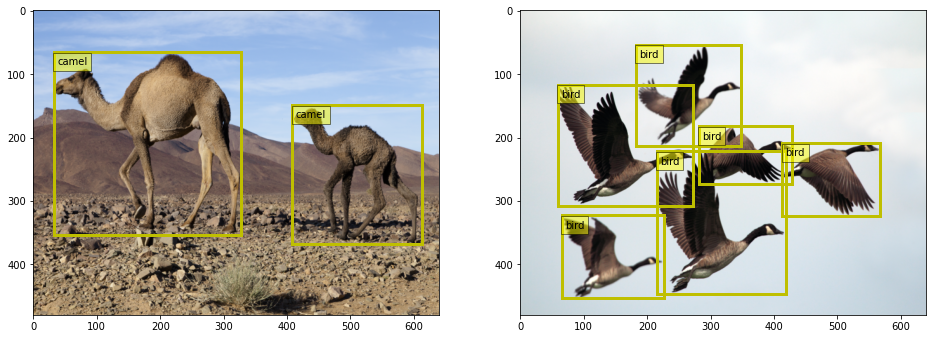

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [ ]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [ ]:
# run the image through the backbone
out = backbone(img_data_all)

In [ ]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [ ]:
out_c, out_h, out_w

(2048, 15, 20)

#### Check how much the image has been down-scaled

In [ ]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

### Visualize feature maps

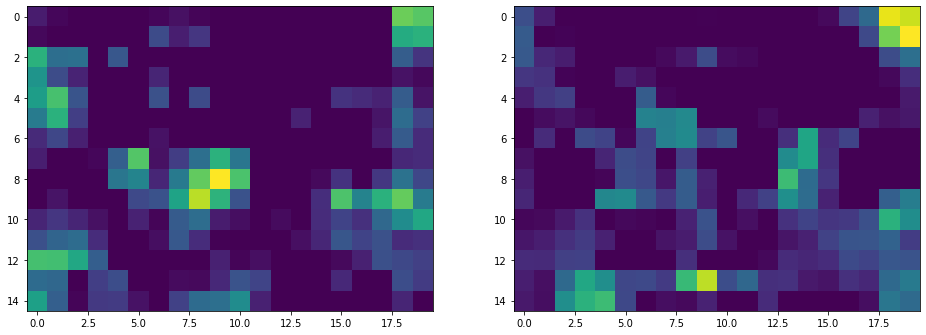

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [ ]:
anc_pts_x, anc_pts_y = rcnn_utils.generate_anchors((out_h, out_w))
print(anc_pts_x)

tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,  7.5000,
         8.5000,  9.5000, 10.5000, 11.5000, 12.5000, 13.5000, 14.5000, 15.5000,
        16.5000, 17.5000, 18.5000, 19.5000])


In [ ]:
anc_pts_x_proj = anc_pts_x * width_scale_factor
anc_pts_y_proj = anc_pts_y * height_scale_factor
print(anc_pts_x_proj)

tensor([ 16.,  48.,  80., 112., 144., 176., 208., 240., 272., 304., 336., 368.,
        400., 432., 464., 496., 528., 560., 592., 624.])


### Display Grid Mapping

In [ ]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

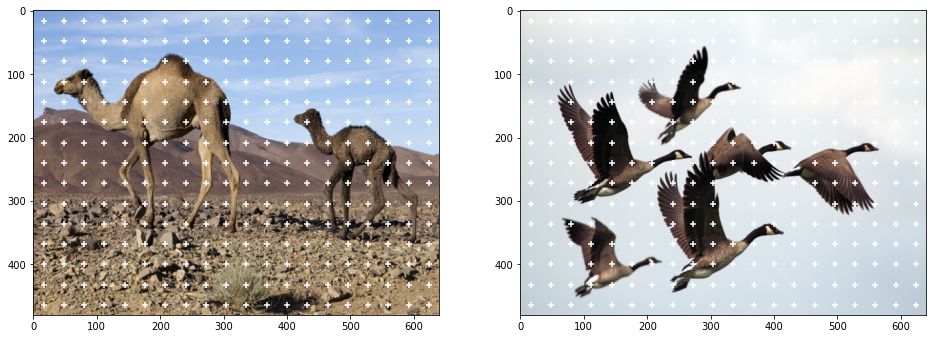

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

### Create Anchor Boxes around Anchor points

In [ ]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
# number of anchor boxes for each anchor point
n_anc_boxes = len(anc_scales) * len(anc_ratios)

anc_base = gen_anc_base(
    anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [ ]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

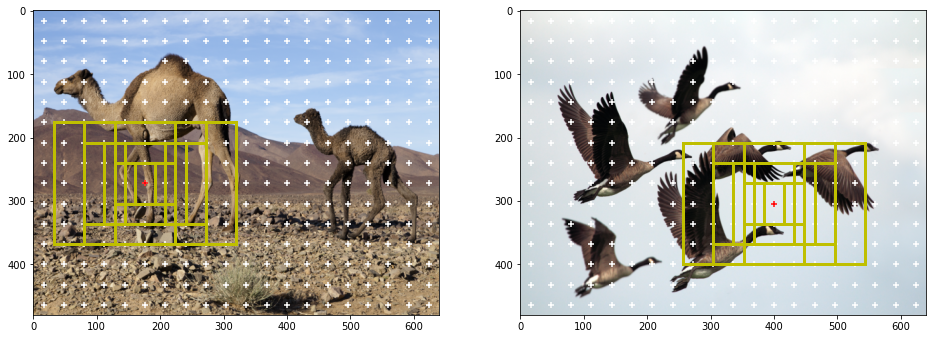

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

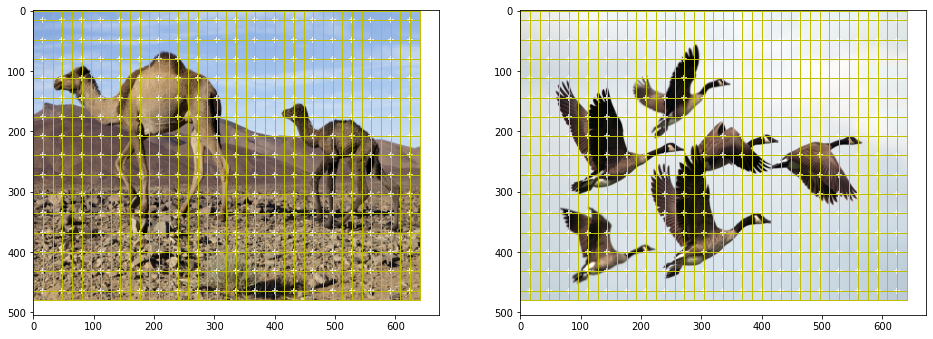

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [ ]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [ ]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

In [ ]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

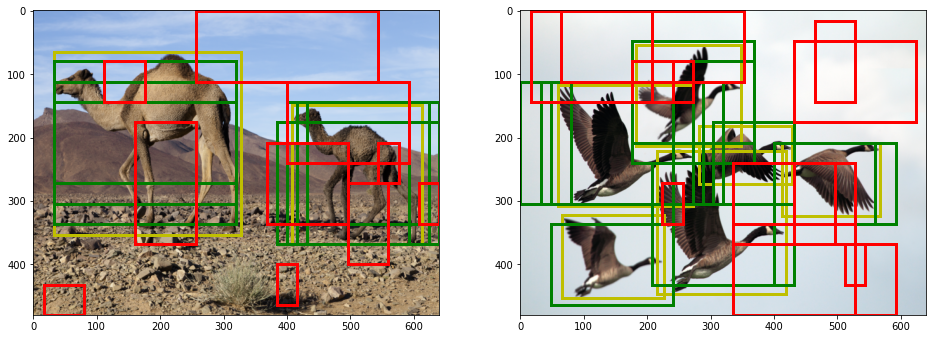

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

### Building the model

In [ ]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [ ]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

### Training loop

In [ ]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [ ]:
learning_rate = 1e-3
n_epochs = 1000

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:28:53<00:00,  8.93s/it]


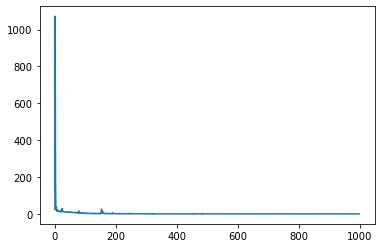

In [ ]:
plt.plot(loss_list)

#### save model

In [ ]:
torch.save(detector.state_dict(), "model.pt")

### Inference

In [ ]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)

In [ ]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)